# Vision Transformer for Malware Classification

## Import the required libraries

In [1]:
import tensorflow as tf
import tensorflow_addons as tfa #For GPU training
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import backend as k
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import regularizers

from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2
from tensorflow.compat.v1.profiler import profile, ProfileOptionBuilder

from keras_tuner import HyperModel
from keras_tuner import RandomSearch

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

from scipy import interp

from classification_models.tfkeras import Classifiers

from collections import Counter

import os #for file reading and writing|
import shutil
import copy
import time
import json

2023-09-08 10:46:48.217496: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-08 10:46:48.667963: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/nikolay/miniconda3/envs/CM3070/lib/python3.11/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


## Data preprocessing: Load the source data

The following code is taken from https://github.com/safreita1/malnet-image/blob/master/process.py, and is a recommended way to assemble the dataset. It was modified to solve a few path building issues and to provide a way to construct a combined train-val split

In [2]:
def filter_types(args, lines):
    """
    Filters out files of specific types ('adware', 'trojan', 'benign', 'riskware') from a list of files. 
    The function checks the type of each file and only includes it in the output if it's not one of the types to exclude.

    Args:
        args (dict): A dictionary containing the following key:
            'image_dir': The directory where the image files are stored.
        lines (list): A list of file names (strings) without the directory path and file extension.

    Returns:
        filtered_files (list): A list of file paths for the files that are not of the types to exclude. The file paths include 
        the directory path and file extension.

    """
    types_to_exclude = ['adware', 'trojan', 'benign', 'riskware']

    filtered_files = []
    files = [args['image_dir'] + file.strip() + '.png' for file in lines]

    for file in files:
        mtype = file.split('malnet-images/')[1].rsplit('/', 2)[0]
        if mtype not in types_to_exclude:
            filtered_files.append(file)

    return filtered_files

def get_split_info(args):
    """
    Retrieves the data file paths and labels for the training, validation, and test datasets. The datasets are 
    organized based on the group type ('binary', 'type', or 'family') and the validation split defined in the 'args' 
    dictionary. The function also prints the paths for the split information and the number of samples in each dataset.

    Args:
        args (dict): A dictionary containing the following keys:
            'group': A string indicating the group type. This can be 'binary', 'type', or 'family'.
            'validation_split': A string indicating the validation split.
            'image_dir': The directory where the image files are stored.
            'malnet_tiny': A boolean flag to determine whether to use a small dataset or not.

    Returns:
        files_train (list): A list of file paths for the training images.
        files_val (list): A list of file paths for the validation images.
        files_test (list): A list of file paths for the test images.
        train_labels (list): A list of labels for the training images.
        val_labels (list): A list of labels for the validation images.
        test_labels (list): A list of labels for the test images.
        label_dict (dict): A dictionary mapping the label names to their corresponding integer indices.

    Raises:
        SystemExit: If the 'group' type is not one of 'binary', 'type', or 'family'.
    """
    # 30.06.2023 fixed the path builder string to include split varition paths
    print('training split path: /split_info/{}/{}/train.txt'.format(args['group'], args['validation_split']))
    with open(os.getcwd() + '/split_info/{}/{}/train.txt'.format(args['group'], args['validation_split']), 'r') as f:
        lines_train = f.readlines()

    print('validation split path: /split_info/{}/{}/val.txt'.format(args['group'], args['validation_split']))
    with open(os.getcwd() + '/split_info/{}/{}/val.txt'.format(args['group'], args['validation_split']), 'r') as f:
        lines_val = f.readlines()

    print('test split path: /split_info/{}/{}/test.txt'.format(args['group'], args['validation_split']))
    with open(os.getcwd() + '/split_info/{}/{}/test.txt'.format(args['group'], args['validation_split']), 'r') as f:
        lines_test = f.readlines()

    if args['malnet_tiny']:
        files_train = filter_types(args, lines_train)
        files_val = filter_types(args, lines_val)
        files_test = filter_types(args, lines_test)
    else:
        files_train = [args['image_dir'] + file.strip() + '.png' for file in lines_train]
        files_val = [args['image_dir'] + file.strip() + '.png' for file in lines_val]
        files_test = [args['image_dir'] + file.strip() + '.png' for file in lines_test]

    if args['group'] == 'type':
        labels = sorted(list(set([file.split('malnet-images/')[1].rsplit('/', 2)[0] for file in files_train])))
        label_dict = {t: idx for idx, t in enumerate(labels)}

        train_labels = [label_dict[file.split('malnet-images/')[1].rsplit('/', 2)[0]] for file in files_train]
        val_labels = [label_dict[file.split('malnet-images/')[1].rsplit('/', 2)[0]] for file in files_val]
        test_labels = [label_dict[file.split('malnet-images/')[1].rsplit('/', 2)[0]] for file in files_test]

    elif args['group'] == 'family':
        labels = sorted(list(set([file.split('malnet-images/')[1].rsplit('/', 2)[1] for file in files_train])))
        label_dict = {t: idx for idx, t in enumerate(labels)}

        train_labels = [label_dict[file.split('malnet-images/')[1].rsplit('/', 2)[1]] for file in files_train]
        val_labels = [label_dict[file.split('malnet-images/')[1].rsplit('/', 2)[1]] for file in files_val]
        test_labels = [label_dict[file.split('malnet-images/')[1].rsplit('/', 2)[1]] for file in files_test]

    elif args['group'] == 'binary':
        labels = ['benign', 'malicious']
        label_dict = {t: idx for idx, t in enumerate(labels)}

        train_labels = [0 if 'benign' in file.split('malnet-images/')[1].rsplit('/', 2)[0] else 1 for file in files_train]
        val_labels = [0 if 'benign' in file.split('malnet-images/')[1].rsplit('/', 2)[0] else 1 for file in files_val]
        test_labels = [0 if 'benign' in file.split('malnet-images/')[1].rsplit('/', 2)[0] else 1 for file in files_test]

    else:
        print('Group does not exist')
        exit(1)

    print('Number of train samples: {}, val samples: {}, test samples: {}'.format(len(files_train), len(files_val), len(files_test)))

    return files_train, files_val, files_test, train_labels, val_labels, test_labels, label_dict

def create_image_symlinks(args):
    """
    Creates symbolic links (symlinks) for the image files in the training, validation, combined train-val and test datasets. The symlinks are 
    organized based on the group type ('binary' or 'family') defined in the 'args' dictionary. The function first retrieves 
    the data file paths for the datasets and then creates symlinks for each file in the appropriate directory.

    Args:
        args (dict): A dictionary containing the following keys:
            'group': A string indicating the group type. This can be 'binary' or 'family'.
            'image_dir': The directory where the image files are stored.
            'data_dir': The directory where the symlinks will be created.

    """
    print('Creating image symlinks')

    files_train, files_val, files_test, _, _, _, _ = get_split_info(args)

    # create symlinks for train/val/test folders
    dst_dir = args['data_dir'] + '{}/'.format(args['group'])

    for src_path in files_train:
        dst_path = src_path.replace(args['image_dir'], dst_dir + 'train/')

        if args['group'] == 'binary':
            if 'benign' not in dst_path:
                dst_path = dst_path.split('train/')[0] + 'train/malicious/' + dst_path.split('train/')[1].split('/')[2]
            else:
                dst_path = dst_path.split('train/')[0] + 'train/benign/' + dst_path.split('train/')[1].split('/')[2]

        elif args['group'] == 'family':
            dst_path = dst_path.split('train/')[0] + 'train/' + '/'.join(dst_path.split('train/')[1].split('/')[1:3])

        if not os.path.exists(dst_path):
            os.makedirs(os.path.dirname(dst_path), exist_ok=True)
            os.symlink(os.getcwd() + src_path, dst_path) # 30.06.2023 fixed a bug that led to creation of broken symlinks 

    for src_path in files_val:
        dst_path = src_path.replace(args['image_dir'], dst_dir + 'val/')

        if args['group'] == 'binary':
            if 'benign' not in dst_path:
                dst_path = dst_path.split('val/')[0] + 'val/malicious/' + dst_path.split('val/')[1].split('/')[2]
            else:
                dst_path = dst_path.split('val/')[0] + 'val/benign/' + dst_path.split('val/')[1].split('/')[2]

        elif args['group'] == 'family':
            dst_path = dst_path.split('val/')[0] + 'val/' + '/'.join(dst_path.split('val/')[1].split('/')[1:3])

        if not os.path.exists(dst_path):
            os.makedirs(os.path.dirname(dst_path), exist_ok=True)
            os.symlink(os.getcwd() + src_path, dst_path)

    for src_path in files_test:
        dst_path = src_path.replace(args['image_dir'], dst_dir + 'test/')

        if args['group'] == 'binary':
            if 'benign' not in dst_path:
                dst_path = dst_path.split('test/')[0] + 'test/malicious/' + dst_path.split('test/')[1].split('/')[2]
            else:
                dst_path = dst_path.split('test/')[0] + 'test/benign/' + dst_path.split('test/')[1].split('/')[2]

        elif args['group'] == 'family':
            dst_path = dst_path.split('test/')[0] + 'test/' + '/'.join(dst_path.split('test/')[1].split('/')[1:3])

        if not os.path.exists(dst_path):
            os.makedirs(os.path.dirname(dst_path), exist_ok=True)
            os.symlink(os.getcwd() + src_path, dst_path)

    for file_list in [files_train, files_val]:
        for src_path in file_list:
            dst_path = src_path.replace(args['image_dir'], dst_dir + 'trainval/')

            if args['group'] == 'binary':
                if 'benign' not in dst_path:
                    dst_path = dst_path.split('trainval/')[0] + 'trainval/malicious/' + dst_path.split('trainval/')[1].split('/')[2]
                else:
                    dst_path = dst_path.split('trainval/')[0] + 'trainval/benign/' + dst_path.split('trainval/')[1].split('/')[2]

            elif args['group'] == 'family':
                dst_path = dst_path.split('trainval/')[0] + 'trainval/' + '/'.join(dst_path.split('trainval/')[1].split('/')[1:3])

            if not os.path.exists(dst_path):
                os.makedirs(os.path.dirname(dst_path), exist_ok=True)
                os.symlink(os.getcwd() + src_path, dst_path)
    
    print('Finished creating symlinks')

## Data preprocessing: Data augmentation

In [3]:
# This implements the Gauss noise as augmentation technique, as suggested in Catak et al's paper
@tf.function
def add_gaussian_noise(image):
    with tf.device('/GPU:0'):
        mean = 0.0
        var = 0.4
        sigma = tf.math.sqrt(var)
        gauss = tf.random.normal(shape=tf.shape(image), mean=mean, stddev=sigma)
        return image + gauss

# Keras ImageGenerator wrapper class that produces input images on both X and Y side
# Used for self-supervised training tasks
class SSTImageGenerator():
    def __init__(self, generator, directory, batch_size, img_height, img_width, class_mode, color_mode, seed, shuffle):
        self.generator = generator.flow_from_directory(directory, target_size=(img_height, img_width),
                                                       class_mode=class_mode, color_mode=color_mode,
                                                       batch_size=batch_size, seed=seed, shuffle=shuffle)
        self.current_index = 0
        
    def __len__(self):
        return len(self.generator)

    def __getitem__(self, index):
        original_batch = self.generator.__getitem__(index)
        x = original_batch[0]
        
        return x, x  # return the same data as both input and target


    def __iter__(self):
        return self

    def __next__(self):
        if self.current_index >= len(self):
            self.current_index = 0
            raise StopIteration
        result = self.__getitem__(self.current_index)
        self.current_index += 1
        return result

    @property
    def batch_index(self):
        return self.generator.batch_index
        
    @property
    def samples(self):
        return self.generator.samples

    @property
    def num_classes(self):
        return self.generator.num_classes

    def reset(self):
        self.current_index = 0
        self.generator.reset()

# Visualize an unmasked/masked sample for debugging
def visualize_masking_sample(data_gen, image_size, patch_size, num_channels, projection_dim, mask_rate):
    # Get normal samples
    batch, _ = data_gen.__getitem__(0)
    data_gen.reset()
    
    print(image_size, patch_size, num_channels)
    patch_layer = Patches(patch_size, num_channels)
    sample_patches = patch_layer(images=batch)
    patch_encoder = PatchEncoder((image_size // patch_size) ** 2, projection_dim, mask_rate)
    reconstructor = RearrangePatchesToImage(patch_size, image_size, num_channels)
    
    masked_patches = patch_encoder.generate_masked_patches(sample_patches)

    # Reshaping sample_patches[0] to be compatible with PatchEncoder reconstruct_single_image
    reshaped_sample_patch = tf.reshape(sample_patches[0], [image_size // patch_size, 
                                                             image_size // patch_size, 
                                                             patch_size, 
                                                             patch_size, 
                                                             num_channels])

    reshaped_masked_patch = tf.reshape(masked_patches[0], [image_size // patch_size, 
                                                             image_size // patch_size, 
                                                             patch_size, 
                                                             patch_size, 
                                                             num_channels])
    
    plt.imshow(reconstructor.reconstruct_single_image(reshaped_sample_patch))
    plt.axis("off")
    plt.show()

    plt.imshow(reconstructor.reconstruct_single_image(reshaped_masked_patch))
    plt.axis("off")
    plt.show()

## Data preprocessing: Create image generators

In [4]:
def get_generators(model_args, data_args):
    """
    Creates data generators for the training, validation, and test datasets using the ImageDataGenerator class from Keras. 
    The datasets are organized based on the group type defined in the 'args' dictionary. The function creates a generator 
    for each dataset, specifying the directory, target size, class mode, color mode, batch size, seed, and shuffle settings.

    Args:
        args (dict): A dictionary containing the following keys:
            'group': A string indicating the group type.
            'data_dir': The directory where the datasets are stored.
            'color_mode': The color mode for the images. Can be 'grayscale', 'rgb', etc.
            'batch_size': The batch size for the generators.
            'seed': A seed for the random number generator to ensure reproducibility.

    Returns:
        train_gen (ImageDataGenerator): The data generator for the training data.
        val_gen (ImageDataGenerator): The data generator for the validation data.
        test_gen (ImageDataGenerator): The data generator for the test data.
        trainval_gen (ImageDataGenerator): The data generator for the combined training and validation data.

    """
    # Base ImageDataGenerator for normalization
    idg = ImageDataGenerator(rescale=1. / 255)
    if (data_args['use_gauss_noise']):
        train_idg = ImageDataGenerator(rescale=1. / 255, preprocessing_function=add_gaussian_noise)
    else:
        train_idg = ImageDataGenerator(rescale=1. / 255)

        val_gen = idg.flow_from_directory(directory='{}{}/val'.format(data_args['data_dir'], data_args['group']),
                                           target_size=(model_args['image_size'], model_args['image_size']),
                                           class_mode='categorical',
                                           color_mode=data_args['color_mode'],
                                           batch_size=model_args['batch_size'],
                                           seed=model_args['seed'],
                                           shuffle=False)
    
        test_gen = idg.flow_from_directory(directory='{}{}/test'.format(data_args['data_dir'], data_args['group']),
                                            target_size=(model_args['image_size'], model_args['image_size']),
                                            class_mode='categorical',
                                            color_mode=data_args['color_mode'],
                                            batch_size=model_args['batch_size'],
                                            seed=model_args['seed'],
                                            shuffle=False)

    if (data_args['self-supervised']):
        train_gen = SSTImageGenerator(generator=idg, directory='{}{}/train'.format(data_args['data_dir'], data_args['group']), 
                                            img_height=model_args['image_size'], 
                                            img_width=model_args['image_size'],
                                            class_mode='categorical',
                                            color_mode=data_args['color_mode'],
                                            batch_size=model_args['batch_size'],
                                            seed=model_args['seed'],
                                            shuffle=True)

        trainval_gen = SSTImageGenerator(generator=idg, directory='{}{}/trainval'.format(data_args['data_dir'], data_args['group']), 
                                            img_height=model_args['image_size'], 
                                            img_width=model_args['image_size'],
                                            class_mode='categorical',
                                            color_mode=data_args['color_mode'],
                                            batch_size=model_args['batch_size'],
                                            seed=model_args['seed'],
                                            shuffle=True)
        
        test_gen = SSTImageGenerator(generator=idg, directory='{}{}/test'.format(data_args['data_dir'], data_args['group']),
                                            img_height=model_args['image_size'], 
                                            img_width=model_args['image_size'],
                                            class_mode='categorical',
                                            color_mode=data_args['color_mode'],
                                            batch_size=model_args['batch_size'],
                                            seed=model_args['seed'],
                                            shuffle=False)
    else:
        train_gen = train_idg.flow_from_directory(directory='{}{}/train'.format(data_args['data_dir'], data_args['group']),
                                                           target_size=(model_args['image_size'], model_args['image_size']),
                                                           class_mode='categorical',
                                                           color_mode=data_args['color_mode'],
                                                           batch_size=model_args['batch_size'],
                                                           seed=model_args['seed'], shuffle=True)
        trainval_gen = train_idg.flow_from_directory(directory='{}{}/trainval'.format(data_args['data_dir'], data_args['group']),
                                                           target_size=(model_args['image_size'], model_args['image_size']),
                                                           class_mode='categorical',
                                                           color_mode=data_args['color_mode'],
                                                           batch_size=model_args['batch_size'],
                                                           seed=model_args['seed'], shuffle=True)

    return train_gen, val_gen, trainval_gen, test_gen

## Models components
The following model components are adapted from the Keras tutorial: https://keras.io/examples/vision/image_classification_with_vision_transformer/

## Model components: Multi-layer perceptron

In [5]:
# Adapted from https://keras.io/examples/vision/image_classification_with_vision_transformer/
# Re-implemented as class, because calling other layers from Transformer block is only allowed with dynamic execution

class MLP(keras.layers.Layer):
    def __init__(self, hidden_units, dropout_rate):
        super(MLP, self).__init__()
        self.hidden_units = hidden_units
        self.dropout_rate = dropout_rate
        self.dense_layers = [keras.layers.Dense(unit, activation=tf.nn.gelu) for unit in hidden_units]
        self.dropout_layers = [keras.layers.Dropout(dropout_rate) for _ in hidden_units]

    def call(self, inputs):
        x = inputs
        for dense, dropout in zip(self.dense_layers, self.dropout_layers):
            x = dense(x)
            x = dropout(x)
        return x

## Model components: Patches layer

In [6]:
# From https://keras.io/examples/vision/image_classification_with_vision_transformer/
class Patches(layers.Layer):
    def __init__(self, patch_size, num_channels):
        super().__init__()
        self.patch_size = patch_size
        self.num_channels = num_channels

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = self.patch_size * self.patch_size * self.num_channels
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])  # Use -1 for the first dimension
        return patches

## Model components: Patch encoder

The PatchEncoder layer will linearly transform a patch by projecting it into a vector of size projection_dim. In addition, it adds a learnable position embedding to the projected vector.

In [7]:
# Base from https://keras.io/examples/vision/image_classification_with_vision_transformer/
# Added patch masking for ViT-VS and ViT-SHERLOCK

class PatchEncoder(layers.Layer):
    """
    Custom layer to encode patches in a Vision Transformer.

    Args:
        num_patches: The number of patches.
        projection_dim: The dimensionality of the projected patch embeddings.
        mask_rate: Fraction of patches to be masked (set to zero). Value should be between 0 and 1.

    """
    
    def __init__(self, num_patches, projection_dim, mask_rate):
        super().__init__()
        self.num_patches = num_patches
        self.projection = keras.layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )
        self.mask_rate = mask_rate

    def generate_masked_patches(self, patches):
        # Generate a binary mask
        batch_size = tf.shape(patches)[0]
        mask = tf.random.uniform((batch_size, self.num_patches)) >= self.mask_rate
        mask = tf.cast(mask, dtype=patches.dtype)

        # Apply the mask to the patches
        masked_patches = patches * tf.reshape(mask, [-1, self.num_patches, 1])
        
        return masked_patches
       
    def call(self, patches):
        masked_patches = self.generate_masked_patches(patches)
        
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(masked_patches) + self.position_embedding(positions)
        
        return encoded

## Model components: Tranformer block and Masked auto encoder

In [8]:
class TransformerBlock(keras.layers.Layer):
    def __init__(self, projection_dim, num_heads):
        super(TransformerBlock, self).__init__()
        self.projection_dim = projection_dim
        self.num_heads = num_heads
        self.transformer_units = [projection_dim * 2, projection_dim]

        self.layer_norm1 = layers.LayerNormalization(epsilon=1e-6)
        self.mha = layers.MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim, dropout=0.1)
        self.layer_norm2 = layers.LayerNormalization(epsilon=1e-6)
        self.mlp_block = MLP(self.transformer_units, dropout_rate=0.1)

    def call(self, inputs):
        # Layer normalization 1 and Multi-head Attention
        x1 = self.layer_norm1(inputs)
        attention_output = self.mha(x1, x1)
        x2 = layers.Add()([attention_output, inputs])

        # Layer normalization 2 and MLP
        x3 = self.layer_norm2(x2)
        mlp_output = self.mlp_block(x3)
        output = layers.Add()([mlp_output, x2])

        return output
        
class MaskedAutoEncoder(keras.Model):
    def __init__(self, patch_size, projection_dim, num_heads, num_decoder_blocks=4):
        super(MaskedAutoEncoder, self).__init__()
        self.patch_size = patch_size
        self.decoder_blocks = [TransformerBlock(projection_dim, num_heads) for _ in range(num_decoder_blocks)]
        self.linear_projection = layers.Dense(patch_size * patch_size * 3)
        self.sigmoid_layer = keras.layers.Activation('sigmoid')

    def call(self, hidden_states):
        # Ducttaping the shaving of classficaiton token
        if (current_experiment == 'ViT-SHERLOCK'):
            x = hidden_states[:, 1:, :]
        else:
            x = hidden_states

        for decoder_block in self.decoder_blocks:
            x = decoder_block(x)

        x = self.linear_projection(x)
        reconstructed_patches = self.sigmoid_layer(x)

        return reconstructed_patches

## Model components: Image reconstructor

In [9]:
class RearrangePatchesToImage(layers.Layer):
    def __init__(self, patch_size, image_size, num_channels):
        super(RearrangePatchesToImage, self).__init__()
        self.patch_size = patch_size
        self.image_size = image_size
        self.num_channels = num_channels

    def call(self, patches):
        # Reshape patches for assembly
        patches_reshaped = tf.reshape(patches, (-1, self.image_size // self.patch_size, self.image_size // self.patch_size, self.patch_size, self.patch_size, self.num_channels))

        # Use tf.map_fn to reconstruct each image
        reconstructed_images = tf.map_fn(self.reconstruct_single_image, patches_reshaped, dtype=tf.float32)

        return reconstructed_images

    # Adaptation from https://keras.io/examples/vision/masked_image_modeling/
    def reconstruct_single_image(self, single_image_patches):
        # Use tf.split and tf.concat to assemble the patches into images
        rows = [tf.concat(tf.unstack(row_patches, axis=0), axis=1) for row_patches in tf.unstack(single_image_patches, axis=0)]
        reconstructed_image = tf.concat(rows, axis=0)
        
        return reconstructed_image

## Vision Transfomer
Revision 29.07.2023 for modularity, because reimplementing the base over and over with 3 vision transformer models takes too much space and gets confusing.
The code is adapted from Keras ViT tutorial: https://keras.io/examples/vision/image_classification_with_vision_transformer/

## ViT-V

In [10]:
def create_ViT_V(data_gen, cfg, data_cfg):
    inputs = layers.Input(shape=(cfg['image_size'], cfg['image_size'], cfg['num_channels']))

    # Create patches
    patches = Patches(cfg['patch_size'], cfg['num_channels'])(inputs)
    
    # Encode patches
    encoded_patches = PatchEncoder((cfg['image_size'] // cfg['patch_size']) ** 2, cfg['projection_dim'], 0)(patches)

    # Create multiple layers of the Transformer block
    for _ in range(cfg['transformer_layers']):
        transformer_block = TransformerBlock(cfg['projection_dim'], cfg['num_heads'])
        encoded_patches = transformer_block(encoded_patches)

    # Create a [batch_size, projection_dim] tensor
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    
    # Add the MLP
    mlp_block = MLP(hidden_units=cfg['mlp_head_units'], dropout_rate=0.5)
    features = mlp_block(representation)

    # Classify outputs
    logits = keras.layers.Dense(data_gen.num_classes)(features)

    # Create the Keras model
    model = keras.Model(inputs=inputs, outputs=logits)
    
    return model

## ViT-B/16

In [11]:
# Construct ViT-B/16 from published weights
# Weights are acquired from here:
# https://github.com/sayakpaul/probing-vits/releases/download/v1.0.0/probing_vits.zip

def create_ViT_B_16(data_gen, cfg, data_cfg):
    # Define the custom input layer
    inputs = keras.Input(shape=(cfg['image_size'], cfg['image_size'], cfg['num_channels']))
    
    # Load the pretrained model
    pretrained_model = keras.models.load_model('models/ViT-B_16/vit_b16_patch16_224-i1k_pretrained', compile=False)

    # Pass the custom input through the pretrained model
    x = pretrained_model(inputs)

    # Add the custom output layer for your classification task
    logits = keras.layers.Dense(data_gen.num_classes)(x)

    # Create a new model with the custom input and output
    model = keras.Model(inputs=inputs, outputs=logits)

    return model

## ViT-SHERLOCK

In [12]:
def create_ViT_SHERLOCK(data_gen, cfg, data_cfg):
    # Define the custom input layer
    inputs = keras.Input(shape=(cfg['image_size'], cfg['image_size'], cfg['num_channels']))
    patches_layer = Patches(cfg['patch_size'], cfg['num_channels'])(inputs)
    encoded_patches = PatchEncoder((cfg['image_size'] // cfg['patch_size']) ** 2, cfg['encoder_projection_dim'], cfg['mask_rate'])(patches_layer)

    # Classification token, otherwise ViT-B/16 base doesn't work
    batch_size = tf.shape(encoded_patches)[0]
    cls_token = tf.keras.layers.Embedding(input_dim=1, output_dim=cfg['encoder_projection_dim'])(tf.zeros((batch_size, 1), dtype=tf.int32))
    encoded_patches = layers.Concatenate(axis=1)([cls_token, encoded_patches])
            
    if (data_cfg['self-supervised']):
        # Load ViT-B/16 weights
        pretrained_model = keras.models.load_model('models/ViT-B_16/vit_b16_patch16_224-i1k_pretrained', compile=False)
        
        encoder_layers = pretrained_model.layers[1:-3]
    
        for layer in encoder_layers:
            if 'transformer_block' in layer.name:
                encoded_patches = layer(encoded_patches)[0] 
                encoded_patches = layers.Lambda(lambda x: x, name=f"lambda_{layer.name}")(encoded_patches)
            else:
                encoded_patches = layer(encoded_patches)
                
        # Project down the encoded patches before decoding
        projection_layer = layers.Dense(cfg['decoder_projection_dim'], activation='linear')
        projected_encoded_patches = projection_layer(encoded_patches)
        
        # Decode the projected encoded patches using the MaskedAutoEncoder
        mae = MaskedAutoEncoder(cfg['patch_size'], cfg['decoder_projection_dim'], cfg['num_heads'])
        reconstructed_patches = mae(projected_encoded_patches)
    
        # Reconstruct the images from patches
        reconstructed_images = RearrangePatchesToImage(cfg['patch_size'], cfg['image_size'], cfg['num_channels'])(reconstructed_patches)
    
        model = keras.Model(inputs=inputs, outputs=reconstructed_images)
    else:
        pretrained_model = keras.models.load_model('models/ViT-B_16/vit_b16_patch16_224-i1k_pretrained', compile=False)
        # x = pretrained_model(inputs)
        encoder_layers = pretrained_model.layers[1:-3]
        pretrained_model.summary()
        
        for layer in encoder_layers:
            if 'transformer_block' in layer.name:
                encoded_patches = layer(encoded_patches)[0] 
                encoded_patches = layers.Lambda(lambda x: x, name=f"lambda_{layer.name}")(encoded_patches)
            else:
                encoded_patches = layer(encoded_patches)
       
        # Create a [batch_size, projection_dim] tensor
        representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        representation = layers.Flatten()(representation)
        representation = layers.Dropout(0.5)(representation)
        
        # # Add the MLP
        # mlp_block = MLP(hidden_units=cfg['mlp_head_units'], dropout_rate=0.5)
        # features = mlp_block(representation)
    
        # Classify outputs
        logits = keras.layers.Dense(data_gen.num_classes)(representation)
    
        # Create the Keras model
        model = keras.Model(inputs=inputs, outputs=logits)       
        model.load_weights('models/ViT-SHERLOCK/encodings/ViT-SHERLOCK_encodings.h5', by_name=True)
        model.summary()
        
    return model

## ViT-VS

In [13]:
# The encoder part is only trainable during self-supervised training stage
# Only the classifier head is tranable for classification

def create_ViT_VS(data_gen, cfg, data_cfg):
    inputs = layers.Input(shape=(cfg['image_size'], cfg['image_size'], cfg['num_channels']))
    
    patches_layer = Patches(cfg['patch_size'], cfg['num_channels'])(inputs)
    
    # Encode patches
    encoded_patches = PatchEncoder((cfg['image_size'] // cfg['patch_size']) ** 2, cfg['encoder_projection_dim'], cfg['mask_rate'])(patches_layer)

    # Apply transformer blocks for encoding
    for _ in range(cfg['encoder_layers']):
        transformer_block = TransformerBlock(cfg['encoder_projection_dim'], cfg['num_heads'])
        encoded_patches = transformer_block(encoded_patches)

    if (data_cfg['self-supervised']):
        # Project down the encoded patches before decoding
        projection_layer = layers.Dense(cfg['decoder_projection_dim'], activation='linear')
        projected_encoded_patches = projection_layer(encoded_patches)
        
        # Decode the projected encoded patches using the MaskedAutoEncoder
        mae = MaskedAutoEncoder(cfg['patch_size'], cfg['decoder_projection_dim'], cfg['num_heads'])
        reconstructed_patches = mae(projected_encoded_patches)
    
        # Reconstruct the images from patches
        reconstructed_images = RearrangePatchesToImage(cfg['patch_size'], cfg['image_size'], cfg['num_channels'])(reconstructed_patches)
    
        model = keras.Model(inputs=inputs, outputs=reconstructed_images)
    else:
        # Classifier head - identical to ViT-V
        # Create a [batch_size, projection_dim] tensor
        representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        representation = layers.Flatten()(representation)
        representation = layers.Dropout(0.5)(representation)
        
        # Add the MLP
        mlp_block = MLP(hidden_units=cfg['mlp_head_units'], dropout_rate=0.5)
        features = mlp_block(representation)
    
        # Classify outputs
        logits = keras.layers.Dense(data_gen.num_classes)(representation)
    
        # Create the Keras model
        model = keras.Model(inputs=inputs, outputs=logits)        
        model.load_weights('models/ViT-VS/encodings/ViT-VS_encodings.h5', by_name=True)

    return model

## Pre-built CNN models

In [14]:
def create_MobileNetV2(data_gen, params):
    base_model = MobileNetV2(input_shape=(params['image_size'], params['image_size'], params['num_channels']), 
                             weights=None, include_top=False)
    
    x = keras.layers.GlobalAveragePooling2D()(base_model.output)
    output = keras.layers.Dense(data_gen.num_classes, activation='softmax')(x)
    model = keras.models.Model(inputs=base_model.input, outputs=output)
    
    return model
    
def create_ResNet18(data_gen, params):
    ResNet18, _ = Classifiers.get('resnet18')
    base_model = ResNet18((params['image_size'], params['image_size'], params['num_channels']), 
                          weights=None, include_top=False)
    
    x = keras.layers.GlobalAveragePooling2D()(base_model.output)
    output = keras.layers.Dense(data_gen.num_classes, activation='softmax')(x)
    model = keras.models.Model(inputs=base_model.input, outputs=output)
    
    return model

## Model building and training

In [15]:
# Helper function mapping
model_builders = {
    'ViT-V': create_ViT_V,
    'ViT-VS': create_ViT_VS,
    'ViT-SHERLOCK': create_ViT_SHERLOCK, #ViT-SHERLOCK is ViT-VS, but with different parameters #, create_ViT_SHERLOCK, 
    'ViT-B_16': create_ViT_B_16,
    'ResNet18': create_ResNet18,
    'MobileNetV2': create_MobileNetV2
}
      
def get_class_weights(data_gen, reweigh, beta=0.999):
    num_classes = data_gen.num_classes
    labels = []

    # Continue iterating until all classes have been seen
    while len(np.unique(labels)) < num_classes:
        for _, batch_labels in data_gen:
            labels += list(np.argmax(batch_labels, axis=-1))
            if len(np.unique(labels)) >= num_classes:
                break

    labels = np.array(labels)
    counter = Counter(labels)
    total_samples = len(labels)

    if reweigh:
        # Calculate effective numbers
        effective_numbers = {cls: (1.0 - beta) / (1.0 - beta**count) for cls, count in counter.items()}
        # Normalize the effective numbers
        total_effective_number = sum(effective_numbers.values())
        class_weight_dict = {cls: eff_num / total_effective_number for cls, eff_num in effective_numbers.items()}
    else:
        class_weight_dict = {cls: count / total_samples for cls, count in counter.items()}

    data_gen.reset()

    return class_weight_dict

def build_model_for_validation(hp, model_name, train_gen, data_cfg):
    model = model_builders[model_name](train_gen, experiments[model_name])
    
    output_logits = True
    
    optimizer = tfa.optimizers.AdamW(
            learning_rate=hp.Choice('learning_rate', values=[experiments[model_name]['learning_rate']]),
            weight_decay=hp.Choice('weight_decay', values=[experiments[model_name]['weight_decay']])
    )

    if (data_cfg['self-supervised']):
        #loss=keras.losses.MeanSquaredError()
        loss=MSELoss(experiments[model_name]['patch_size'])
        #metrics=[keras.metrics.MeanSquaredError(name="mse")]
        metrics=[MSEMetric(experiments[model_name]['patch_size'], name="custom_mse")]
    else:
        loss=keras.losses.CategoricalCrossentropy(from_logits=output_logits)
        metrics=[keras.metrics.CategoricalAccuracy(name="accuracy"), 
                 keras.metrics.TopKCategoricalAccuracy(5, name="top-5-accuracy")]
        
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    return model

def build_model_for_training(hp, model_name, train_gen, data_cfg):
    model = model_builders[model_name](train_gen, experiments[model_name], data_cfg)
    
    output_logits = True

    if model_name == "ResNet18":
        output_logits = False
        #optimizer = tfa.optimizers.SGDW(learning_rate=hp['learning_rate'], momentum=0.9, weight_decay=hp['weight_decay'])
        optimizer = tfa.optimizers.AdamW(learning_rate=hp['learning_rate'], weight_decay=hp['weight_decay'])
    elif model_name == "MobileNetV2":
        output_logits = False
        lr_schedule = keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate=hp['learning_rate'],
            decay_steps=1000,
            decay_rate=0.98
        )
        optimizer = keras.optimizers.RMSprop(learning_rate=lr_schedule)
    else:
        optimizer = tfa.optimizers.AdamW(learning_rate=hp['learning_rate'], weight_decay=hp['weight_decay'])

    if (data_cfg['self-supervised']):
        #loss=keras.losses.MeanSquaredError()
        loss=MSELoss(experiments[model_name]['patch_size'])
        #metrics=[keras.metrics.MeanSquaredError(name="mse")]
        metrics=[MSEMetric(experiments[model_name]['patch_size'], name="custom_mse")]
    else:
        loss=keras.losses.CategoricalCrossentropy(from_logits=output_logits)
        metrics=[keras.metrics.CategoricalAccuracy(name="accuracy"), 
                 keras.metrics.TopKCategoricalAccuracy(5, name="top-5-accuracy")]
        
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    return model

def validate_parameters(model, train_gen, val_gen, class_weights, model_directory, data_cfg):
    if (data_cfg['self-supervised']):
        objective='val_mse'
    else:
        objective='val_accuracy'
   
    tuner = RandomSearch(
        hypermodel=lambda hp: build_model_for_validation(hp, model, train_gen),
        objective=objective,
        max_trials=1,
        executions_per_trial=1,
        directory=model_directory,
        project_name=model,
    )
        
    tuner.search_space_summary()

    # Stop training if loss doesnt improve after 5 epochs
    callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0)]

    if (class_weights == None):
        tuner.search(train_gen,
                     validation_data=val_gen,
                     steps_per_epoch=int(train_gen.samples / experiments[model]['batch_size']),
                     validation_steps=int(val_gen.samples / experiments[model]['batch_size']),
                     epochs=experiments[model]['validation_epochs'], callbacks=callbacks
                     )
    else:
        tuner.search(train_gen,
                     validation_data=val_gen,
                     steps_per_epoch=int(train_gen.samples / experiments[model]['batch_size']),
                     validation_steps=int(val_gen.samples / experiments[model]['batch_size']),
                     epochs=experiments[model]['validation_epochs'], callbacks=callbacks, class_weight=class_weights
                     )

    return tuner

# Custom callback to reset the generator at an end of training epoch
class ManualGeneratorResetOEE(keras.callbacks.Callback):
    def __init__(self, generator):
        super(ManualGeneratorResetOEE, self).__init__()
        self.generator = generator

    def on_epoch_end(self, epoch, logs=None):
        self.generator.reset()
        
class MSEMetric(tf.keras.metrics.Metric):
    def __init__(self, patch_size, name="custom_mse", **kwargs):
        super(MSEMetric, self).__init__(name=name, **kwargs)
        self.patch_size = patch_size
        self.mse_sum = self.add_weight(name="mse_sum", initializer="zeros")
        self.sample_count = self.add_weight(name="sample_count", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Normalize each patch in y_true and y_pred
        y_true_patches = tf.image.extract_patches(y_true,
                                                  sizes=[1, self.patch_size, self.patch_size, 1],
                                                  strides=[1, 1, 1, 1],
                                                  rates=[1, 1, 1, 1],
                                                  padding="VALID")
        
        y_pred_patches = tf.image.extract_patches(y_pred,
                                                  sizes=[1, self.patch_size, self.patch_size, 1],
                                                  strides=[1, 1, 1, 1],
                                                  rates=[1, 1, 1, 1],
                                                  padding="VALID")
        
        y_pred_mean, y_pred_var = tf.nn.moments(y_pred, axes=[-1], keepdims=True)

        # Resize to match the original dimensions
        y_pred_mean_resized = tf.image.resize(y_pred_mean, [224, 224])
        y_pred_std_resized = tf.sqrt(tf.image.resize(y_pred_var, [224, 224]) + 1e-7)

        y_true_mean, y_true_var = tf.nn.moments(y_true, axes=[-1], keepdims=True)
        y_true_std = tf.sqrt(y_true_var + 1e-7)

        y_true_normalized = (y_true - y_true_mean) / y_true_std
        y_pred_normalized = (y_pred - y_pred_mean_resized) / y_pred_std_resized

        mse = tf.reduce_mean(tf.square(y_true_normalized - y_pred_normalized))
        
        # Update sum of MSE and sample count
        self.mse_sum.assign_add(mse)
        self.sample_count.assign_add(1)

    def result(self):
        return self.mse_sum / self.sample_count

    def reset_states(self):
        self.mse_sum.assign(0.0)
        self.sample_count.assign(0.0)
        
def MSELoss(patch_size):
    def mean_error_over_pixes(y_true, y_pred):   
        y_true_patches = tf.image.extract_patches(y_true,
                                                  sizes=[1, patch_size, patch_size, 1],
                                                  strides=[1, 1, 1, 1],
                                                  rates=[1, 1, 1, 1],
                                                  padding="VALID")
        
        y_pred_patches = tf.image.extract_patches(y_pred,
                                                  sizes=[1, patch_size, patch_size, 1],
                                                  strides=[1, 1, 1, 1],
                                                  rates=[1, 1, 1, 1],
                                                  padding="VALID")
        
        y_pred_mean, y_pred_var = tf.nn.moments(y_pred, axes=[-1], keepdims=True)

        # Resize to match the original dimensions
        y_pred_mean_resized = tf.image.resize(y_pred_mean, [224, 224])
        y_pred_std_resized = tf.sqrt(tf.image.resize(y_pred_var, [224, 224]) + 1e-7)

        y_true_mean, y_true_var = tf.nn.moments(y_true, axes=[-1], keepdims=True)
        y_true_std = tf.sqrt(y_true_var + 1e-7)

        y_true_normalized = (y_true - y_true_mean) / y_true_std
        y_pred_normalized = (y_pred - y_pred_mean_resized) / y_pred_std_resized

        mse = tf.reduce_mean(tf.square(y_true_normalized - y_pred_normalized))

        return mse
        
    return mean_error_over_pixes
    
def train_model(model_name, train_gen, val_gen, trainval_gen, class_weights, data_cfg, model_directory):   
    if (data_cfg['skip_validation']):
        best_hps = {'learning_rate': experiments[model_name]['learning_rate'], 'weight_decay': experiments[model_name]['weight_decay']}
        best_model = build_model_for_training(best_hps, model_name, train_gen, data_cfg)
    else:
        print("Parameter validation stage")
        tuner = validate_parameters(model_name, train_gen, val_gen, class_weights, model_directory, data_cfg)
        best_hps = tuner.get_best_hyperparameters()[0].values
        best_model = build_model_for_training(best_hps, model_name, train_gen, data_cfg)

    with open(f'{model_directory}/{model_name}_summary.txt', 'w') as f:
        best_model.summary(print_fn=lambda x: f.write(x + '\n'))

    if (data_cfg['self-supervised']):
        monitor='custom_mse'
    else:
        monitor='val_loss'
        
    # If loss does not improve after 10 epochs, stop
    es = keras.callbacks.EarlyStopping(monitor=monitor, patience=10, verbose=0)
    mc = keras.callbacks.ModelCheckpoint(f'{model_directory}/checkpoints/{model_name}_{data_cfg["group"]}.h5', monitor=monitor,save_best_only=True,save_weights_only=True)
    gr = ManualGeneratorResetOEE(trainval_gen)
        
    rlrop = keras.callbacks.ReduceLROnPlateau(monitor=monitor, factor=0.1, patience=3, min_lr=1e-8)

    if (model_name == 'ViT-VS' or model_name == 'ViT-SHERLOCK'):
        visualize_masking_sample(trainval_gen, experiments[model_name]['image_size'], 
                                       experiments[model_name]['patch_size'], 
                                       experiments[model_name]['num_channels'],
                                       experiments[model_name]['encoder_projection_dim'],
                                       experiments[model_name]['mask_rate'] )
        
    if (data_cfg['self-supervised']): # ViT-VS and ViT-SHERLOCK       
        history = best_model.fit(trainval_gen,
                                 epochs=experiments[model_name]['num_epochs'], 
                                 steps_per_epoch=(trainval_gen.samples // experiments[model_name]['batch_size']), 
                                 callbacks=[es,mc,gr,rlrop]) # Enable LR reduction due to longer training time
    else:
        history = best_model.fit(trainval_gen,
                                 validation_data=val_gen, 
                                 epochs=experiments[model_name]['num_epochs'], 
                                 steps_per_epoch=(train_gen.samples // experiments[model_name]['batch_size']), 
                                 callbacks=[es, mc],#, rlrop],
                                 class_weight=class_weights)

    return best_model, best_hps, history

## Model evaluation 

In [16]:
def evaluate_model(model, model_name, test_gen):
    _, accuracy, top_5_accuracy = model.evaluate(test_gen, steps=int(test_gen.samples / experiments[model_name]['batch_size']))
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Top-5 accuracy: {round(top_5_accuracy * 100, 2)}%")
    
    test_gen.reset()  # To ensure the generator starts from the beginning

    start_time = time.time()  # start timing
    predictions = model.predict(test_gen, steps=np.ceil(test_gen.samples / experiments[model_name]['batch_size']))
    end_time = time.time()  # end timing

    inference_time = end_time - start_time

    predicted_classes = np.argmax(predictions, axis=1)

    return predicted_classes, inference_time

def plot_trainval_graph(model_name, history, data_cfg, model_directory):
    plt.figure(figsize=(10, 8))
    if (data_cfg['self-supervised']):
        plt.plot(history.history['custom_mse'])
    else:
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        
    plt.title(f'{model_name} loss ({data_cfg["group"]} classification task)')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.savefig(f'{model_directory}/{model_name}_{data_cfg["group"]}_loss.png', dpi=800)
    plt.show()

def plot_roc_graph(model, model_name, test_gen, data_cfg, model_directory):
    n_classes = test_gen.num_classes #len(test_gen.class_indices)
    
    # Get true labels and binarize
    true_labels = test_gen.classes
    true_labels_binarized = label_binarize(true_labels, classes=np.arange(n_classes))
    
    # Get predicted probabilities
    predicted_probs = model.predict(test_gen)

    if n_classes == 2:
        true_labels_binarized = label_binarize(true_labels, classes=[0, 1])
        fpr, tpr, _ = roc_curve(true_labels_binarized[:, 0], predicted_probs[:, 0])
        roc_auc = auc(fpr, tpr)

        # Plot ROC curve for binary classification
        plt.figure(figsize=(10, 8))
        plt.plot(fpr, tpr, lw=2, label='ROC curve (area = {0:0.2f})'.format(roc_auc))
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'{model_name} Receiver Operating Characteristic (ROC) ({data_cfg["group"]} classification task)')
        plt.legend(loc="lower right")
        plt.savefig(f'{model_directory}/{model_name}_{data_cfg["group"]}_ROC.png', dpi=800)
        plt.show()

    else:
        true_labels_binarized = label_binarize(true_labels, classes=np.arange(n_classes))

        # Compute ROC curve and ROC area for each class
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(true_labels_binarized[:, i], predicted_probs[:, i])

        # Compute macro-average ROC curve and ROC area
        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(n_classes):
            mean_tpr += interp(all_fpr, fpr[i], tpr[i])
        mean_tpr /= n_classes

        fpr["macro"] = all_fpr
        tpr["macro"] = mean_tpr
        roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

        # Plot macro-average ROC curve
        plt.figure(figsize=(10, 8))
        plt.plot(fpr["macro"], tpr["macro"], lw=2, label='Macro-average ROC curve (area = {0:0.2f})'.format(roc_auc["macro"]))
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'{model_name} Receiver Operating Characteristic (ROC) ({data_cfg["group"]} classification task)')
        plt.legend(loc="lower right")
        plt.savefig(f'{model_directory}/{model_name}_{data_cfg["group"]}_ROC.png', dpi=800)
        plt.show()
    
def plot_confusion_matrix(model_name, predicted_classes, test_gen, data_cfg, model_directory):
    conf_matrix = confusion_matrix(test_gen.classes, predicted_classes)
    
    plt.rcParams['font.size'] = 7
    plt.figure(figsize=(16, 12))
    class_names = list(test_gen.class_indices.keys())
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'{model_name} Confusion Matrix ({data_cfg["group"]} classification task)')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.savefig(f'{model_directory}/{model_name}_{data_cfg["group"]}_CM.png', dpi=800)
    plt.show()    

def print_classification_report(model_name, predicted_classes, test_gen, data_cfg, model_directory):
    #F1-score, precision, and recall
    classif_report = classification_report(test_gen.classes, predicted_classes, target_names=test_gen.class_indices.keys(), output_dict=True)
    classif_report_df = pd.DataFrame(classif_report).transpose()
  
    print("Classification Report: \n")
    print(classif_report_df)

    with open(f'{model_directory}/{model_name}_{data_cfg["group"]}_classification_report.json', 'w') as f:
        json.dump(classif_report, f)

def profile_model_peformance(model_name, model, data_cfg, model_directory):
    if (data_cfg['self-supervised']):
        metric='custom_mse'
    else:
        metric='accuracy'
        
    with open(f'{model_directory}/{model_name}_{data_cfg["group"]}_training_history.txt', 'w') as file:
        file.write(f'Epoch\tLoss\t{metric}\n')
        for epoch, (loss, acc) in enumerate(zip(history.history['loss'], history.history[f'{metric}'])):
            file.write(f'{epoch}\t{loss}\t{acc}\n')
            
    @tf.function
    def run_model(inputs):
        return model(inputs, training=False)
    
    # Create a TensorSpec
    input_spec = tf.TensorSpec(shape=[experiments[model_name]['batch_size'], experiments[model_name]['image_size'], 
                                      experiments[model_name]['image_size'], experiments[model_name]['num_channels']], dtype=tf.float32)
    
   # Start profiling
    options = tf.profiler.experimental.ProfilerOptions(host_tracer_level = 3,
                                                       python_tracer_level = 1,
                                                       device_tracer_level = 1)

    tf.profiler.experimental.start(f'{model_directory}/profiler_eval'.format(model_name))
    
    # Run the model
    concrete_func = run_model.get_concrete_function(input_spec)
    
    # Stop profiling
    tf.profiler.experimental.stop()
      
    frozen_func = convert_variables_to_constants_v2(concrete_func)    
    flops = profile(frozen_func.graph, options=ProfileOptionBuilder.float_operation())

    with open(f'{model_directory}/{model_name}_{data_cfg["group"]}_GLOPs_Inference.txt', 'w') as f:
        f.write('GFLOPs: {}\n'.format(flops.total_float_ops / 1e9))
        f.write('Inference time: {}\n'.format(inference_time))
        
def display_evaluation_metrics(model_name, model, history, predicted_classes, inference_time, test_gen, data_cfg, model_directory):
    plot_trainval_graph(model_name, history, data_cfg, model_directory)
    profile_model_peformance(model_name, model, data_cfg, model_directory)

    if (not data_cfg['self-supervised']): # applicable only for downstream tasks
        plot_roc_graph(model, model_name, test_gen, data_cfg, model_directory)
        plot_confusion_matrix(model_name, predicted_classes, test_gen, data_cfg, model_directory)
        print_classification_report(model_name, predicted_classes, test_gen, data_cfg, model_directory)
    
def run_experiment(model, data_cfg, model_directory):
    train_gen, val_gen, trainval_gen, test_gen = get_generators(experiments[model], data_cfg)
    class_weights = get_class_weights(val_gen, data_cfg['class_balancing']) 
    
    # Modify 'group' and update model directory to avoid changes to control flow
    if (data_cfg['self-supervised']):
        data_cfg['group'] = 'encodings'
        model_directory = f'models/{current_experiment}/{data_cfg["group"]}'
        class_weights = None # discard class weights

    os.makedirs(model_directory, exist_ok=True)
    best_model, best_hps, history = train_model(model, train_gen, val_gen, trainval_gen, class_weights, data_cfg, model_directory)
    if (data_cfg['self-supervised']):
        predictions = None
        inference_time = None
    else:
        predictions, inference_time = evaluate_model(best_model, model, test_gen)
        
    return model, best_model, best_hps, predictions, inference_time, history, test_gen

## Experiment setup

In [17]:
def setup_experiment(current_experiment, task, tiny, mixup, gauss, reweigh, skip_validation, self_supervised):
    experiments = {}
    with open(f'models/{current_experiment}-params.json', 'r') as f:
        experiments[current_experiment] = json.load(f)
    
    data_cfg = {
        'color_mode': 'rgb',  # options: rgb, grayscale
        'validation_split': 1.0,
        'malnet_tiny': tiny, # MalNet-tiny speeds up testing
        'use_mixup': mixup, # causes overfitting, maybe doesn't make sense at all in context of malware detection
        'use_gauss_noise': gauss,
        'class_balancing': reweigh,
        'skip_validation': skip_validation,
        'self-supervised': self_supervised,
        'group': task,  # options: binary, type, family
        'data_dir': os.getcwd() + '/data/',  # symbolic link directory
        'image_dir': '/malnet-images/'  # path where data is located
    }
    
    # # Dataset construction block
    if os.path.exists('data'):
        shutil.rmtree('data')
    
    create_image_symlinks(data_cfg)
       
    np.random.seed(experiments[current_experiment]['seed'])
    tf.random.set_seed(experiments[current_experiment]['seed'])

    model_directory = f'models/{current_experiment}/{data_cfg["group"]}'

    return experiments, data_cfg, model_directory

## Running the experiment

Creating image symlinks
training split path: /split_info/family/1.0/train.txt
validation split path: /split_info/family/1.0/val.txt
test split path: /split_info/family/1.0/test.txt
Number of train samples: 883416, val samples: 126202, test samples: 252406
Finished creating symlinks
Found 126202 images belonging to 696 classes.
Found 252406 images belonging to 696 classes.
Found 883416 images belonging to 696 classes.
Found 1009618 images belonging to 696 classes.


2023-09-08 10:51:10.204972: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-08 10:51:10.222407: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-08 10:51:10.222562: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Model: "vi_t_classifier_extended"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 projection (Sequential)     (None, 196, 768)          590592    
                                                                 
 transformer_block_0 (Functi  [(None, 197, 768),       7087872   
 onal)                        (None, 12, None, None)]            
                                                                 
 transformer_block_1 (Functi  [(None, 197, 768),       7087872   
 onal)                        (None, 12, None, None)]            
                                                                 
 transformer_block_2 (Functi  [(None, 197, 768),       7087872   
 onal)                        (None, 12, None, None)]            
                                                                 
 transformer_block_3 (Functi  [(None, 197, 768),       7087872   
 onal)                        (None, 12, N

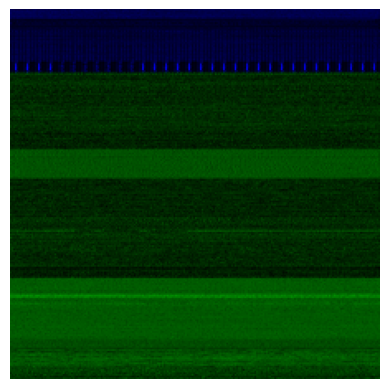

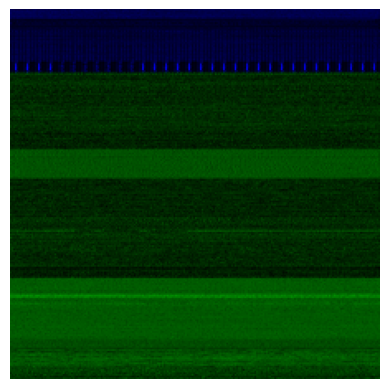

Epoch 1/10


2023-09-08 10:51:16.466758: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-09-08 10:51:16.543640: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'input_tensor' with dtype float and shape [?,197,768]
	 [[{{node input_tensor}}]]
2023-09-08 10:51:16.582045: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'input_tensor' with dtype float and shape [?,197,768]
	 [[{{node inp

13803/13803 [==============================] - ETA: 0s - loss: 2.6646e-04 - accuracy: 0.1738 - top-5-accuracy: 0.3865

2023-09-08 12:03:12.349062: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


13803/13803 [==============================] - 4542s 329ms/step - loss: 2.6646e-04 - accuracy: 0.1738 - top-5-accuracy: 0.3865 - val_loss: 3.8700 - val_accuracy: 0.2597 - val_top-5-accuracy: 0.4877
Epoch 2/10
13803/13803 [==============================] - 4749s 344ms/step - loss: 1.9438e-04 - accuracy: 0.2660 - top-5-accuracy: 0.4972 - val_loss: 3.8562 - val_accuracy: 0.2613 - val_top-5-accuracy: 0.4936
Epoch 3/10
13803/13803 [==============================] - 4767s 345ms/step - loss: 1.8541e-04 - accuracy: 0.2838 - top-5-accuracy: 0.5105 - val_loss: 3.8948 - val_accuracy: 0.2838 - val_top-5-accuracy: 0.5069
Epoch 4/10
13803/13803 [==============================] - 4614s 334ms/step - loss: 1.8242e-04 - accuracy: 0.2902 - top-5-accuracy: 0.5156 - val_loss: 3.7655 - val_accuracy: 0.2964 - val_top-5-accuracy: 0.5147
Epoch 5/10
13803/13803 [==============================] - 4504s 326ms/step - loss: 1.7915e-04 - accuracy: 0.2940 - top-5-accuracy: 0.5204 - val_loss: 3.4480 - val_accuracy: 0.

2023-09-08 23:52:45.805976: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


3943/3943 [==============================] - 466s 118ms/step - loss: 3.6329 - accuracy: 0.3083 - top-5-accuracy: 0.5509
Test accuracy: 30.83%
Top-5 accuracy: 55.09%


2023-09-09 00:00:32.015260: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


3944/3944 [==============================] - 456s 115ms/step


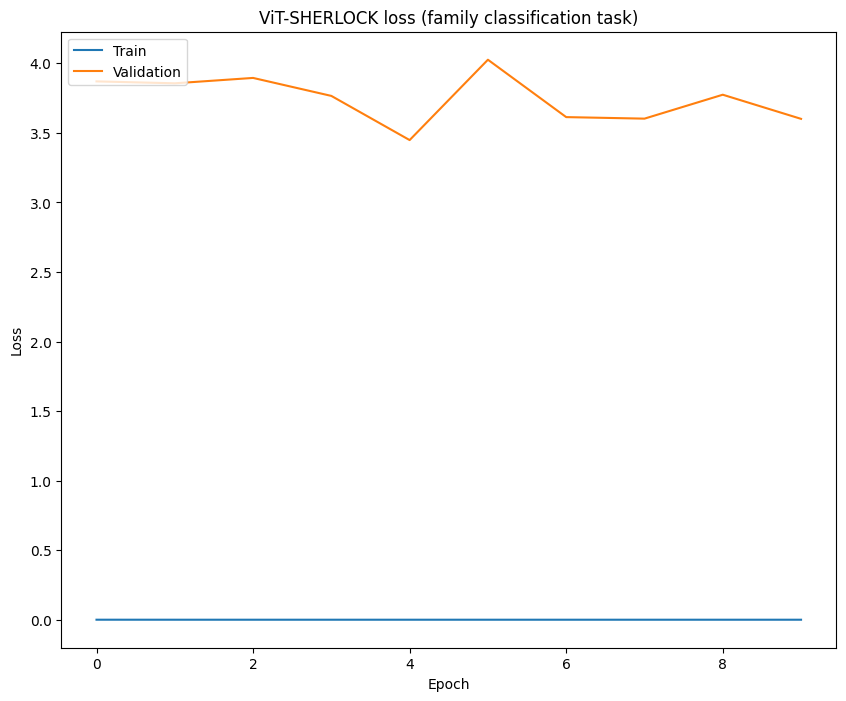

2023-09-09 00:08:10.911529: I tensorflow/tsl/profiler/lib/profiler_session.cc:104] Profiler session initializing.
2023-09-09 00:08:10.911549: I tensorflow/tsl/profiler/lib/profiler_session.cc:119] Profiler session started.
2023-09-09 00:08:10.911584: I tensorflow/compiler/xla/backends/profiler/gpu/cupti_tracer.cc:1679] Profiler found 1 GPUs
2023-09-09 00:08:11.284900: I tensorflow/tsl/profiler/lib/profiler_session.cc:70] Profiler session collecting data.
2023-09-09 00:08:11.285054: I tensorflow/compiler/xla/backends/profiler/gpu/cupti_tracer.cc:1813] CUPTI activity buffer flushed
2023-09-09 00:08:11.291048: I tensorflow/compiler/xla/backends/profiler/gpu/cupti_collector.cc:541]  GpuTracer has collected 0 callback api events and 0 activity events. 
2023-09-09 00:08:11.291588: I tensorflow/tsl/profiler/lib/profiler_session.cc:131] Profiler session tear down.
2023-09-09 00:08:11.300174: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from

Instructions for updating:
This API was designed for TensorFlow v1. See https://www.tensorflow.org/guide/migrate for instructions on how to migrate your code to TensorFlow v2.

=========================Options=============================
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              1
-min_occurrence             0
-step                       -1
-order_by                   float_ops
-account_type_regexes       .*
-start_name_regexes         .*
-trim_name_regexes          
-show_name_regexes          .*
-hide_name_regexes          
-account_displayed_op_only  true
-select                     float_ops
-output                     stdout:

==================Model Analysis Report======================

Doc:
scope: The nodes in the model g

2023-09-09 00:08:30.565694: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


3944/3944 [==============================] - 456s 116ms/step


/tmp/ipykernel_78929/4148675611.py:75: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


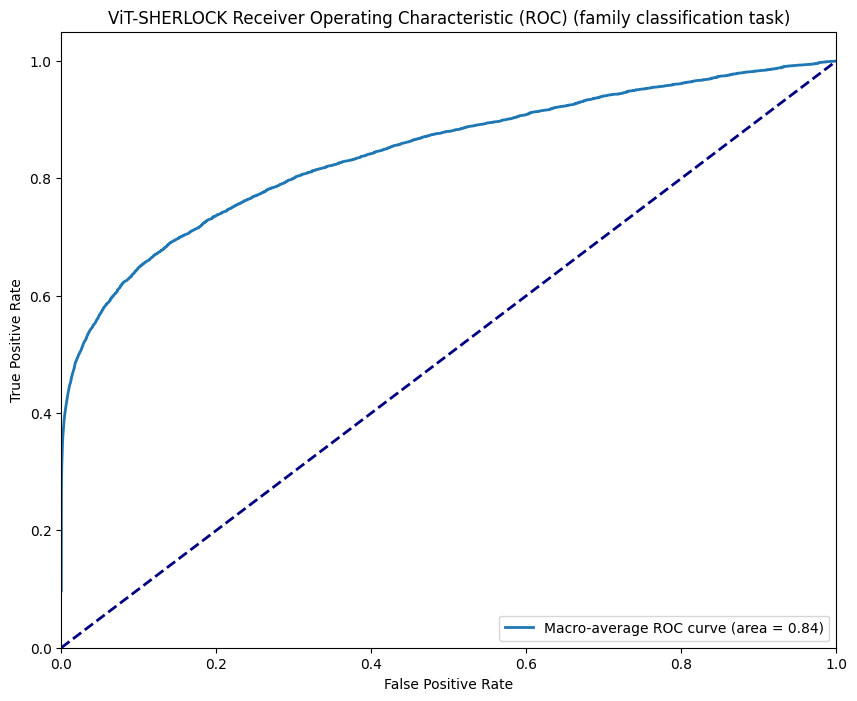

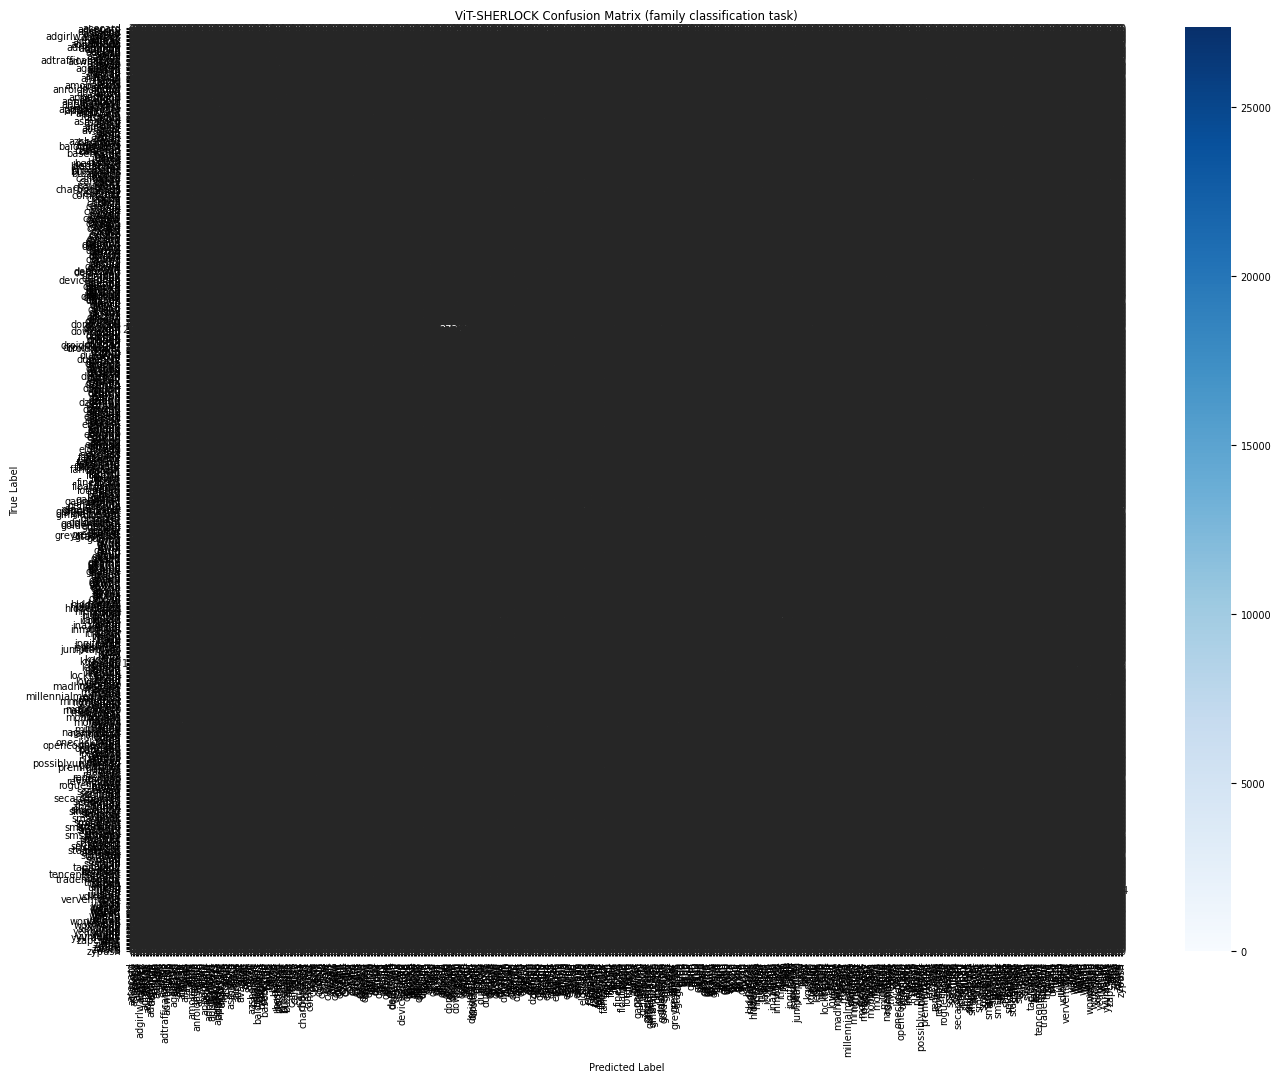

/home/nikolay/miniconda3/envs/CM3070/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/nikolay/miniconda3/envs/CM3070/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/nikolay/miniconda3/envs/CM3070/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,

Classification Report: 

              precision    recall  f1-score        support
acecard        0.003497  0.400000  0.006932       5.000000
ackposts       0.083333  0.173913  0.112676      23.000000
adcolony       0.227273  0.047022  0.077922     319.000000
adend          0.562771  0.992366  0.718232     131.000000
adfeiwo        0.000000  0.000000  0.000000       3.000000
...                 ...       ...       ...            ...
zwalls         0.053097  0.352941  0.092308      17.000000
zypush         0.000000  0.000000  0.000000      31.000000
accuracy       0.308293  0.308293  0.308293       0.308293
macro avg      0.209243  0.273213  0.163750  252406.000000
weighted avg   0.494267  0.308293  0.335375  252406.000000

[699 rows x 4 columns]


NotImplementedError: 

In [18]:
current_experiment = 'ViT-SHERLOCK' #'ViT-V', 'ViT-VS', 'ViT-B_16', 'ViT-SHERLOCK', 'ResNet18', 'MobileNetV2'
current_task = 'family'

experiments, data_cfg, model_directory = setup_experiment(current_experiment, current_task, False, False, False, True, True, False)

model_name, best_model, best_hps, predictions, inference_time, history, test_gen = run_experiment(current_experiment, data_cfg, model_directory)

if (data_cfg['self-supervised']):
    data_cfg['group'] = 'encodings'
    model_directory = f'models/{current_experiment}/{data_cfg["group"]}'
    
display_evaluation_metrics(model_name, best_model, history, predictions, inference_time, test_gen, data_cfg, model_directory)
    
# Save the best model
best_model.save(f'{model_directory}/{model_name}_{data_cfg["group"]}.h5')

k.clear_session()